# Qualitative vs Quantitative Sleep
This notebook looks exclusively at sleep quality as reported by the participants versus what Fitbit was able to measure.

The notebook is organized as follows:
1. [Data Import and Pre-Processing](#import)
2. [Processing](#process)
3. [Visualization and Analysis](#visualize)

# Data Import

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import os

## Fitbit Data
Luckily, the fitbit data as already been processed and stored in ```/data/processed/```.

In [2]:
sleepSummary = pd.read_csv('/Users/hagenfritz/Projects/utx000/data/processed/ut3000-fitbit-sleepstagesummary.csv',
                          index_col=0,parse_dates=True,infer_datetime_format=True)

sleepSummary['TotalHoursAsleep'] = sleepSummary['TotalMinutesAsleep']/60
sleepSummary['TotalHoursREM'] = sleepSummary['TotalMinutesREM']/60
sleepSummary['TotalHoursNREM'] = sleepSummary['TotalMinutesNREM']/60

sleepSummary.head()

,Id,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed,TotalTimeAwake,TotalMinutesLight,TotalMinutesDeep,TotalMinutesREM,study,record,beiwe,beacon,TotalMinutesNREM,REM:NREM,TotalHoursAsleep,TotalHoursREM,TotalHoursNREM
SleepDay,,,,,,,,,,,,,,,,,
2018-10-30,1025,1,293,346,53,203,45,45,ut1000,1025,2qki3fim,NaN,248,0.181452,4.883333,0.750000,4.133333
2018-10-31,1025,1,523,575,52,308,113,102,ut1000,1025,2qki3fim,NaN,421,0.242280,8.716667,1.700000,7.016667
2018-11-01,1025,1,288,326,38,169,47,72,ut1000,1025,2qki3fim,NaN,216,0.333333,4.800000,1.200000,3.600000
2018-11-02,1025,1,529,592,63,316,99,114,ut1000,1025,2qki3fim,NaN,415,0.274699,8.816667,1.900000,6.916667
2018-11-03,1025,1,415,480,65,237,96,82,ut1000,1025,2qki3fim,NaN,333,0.246246,6.916667,1.366667,5.550000


## Beiwe Data
The beiwe data have been processed to different extents depending on the study. Peter Wu has summarized the sleep data nicely for the UT2000 study.

In [3]:
def combine_beiwe_studies(fileString='sleep'):
    '''
    
    '''
    df = pd.DataFrame()
    for i in range(2):
        temp = pd.read_csv(f'/Users/hagenfritz/Projects/utx000/data/raw/ut{i+1}000/beiwe/{fileString}.csv')
        temp['study'] = f'ut{i+1}000'

        crossover = pd.read_csv(f'/Users/hagenfritz/Projects/utx000/data/raw/ut{i+1}000/admin/id_crossover.csv')
        temp = pd.merge(left=temp,right=crossover,left_on='pid',right_on='beiwe',how='left')
        df = pd.concat([df,temp])
        
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date',inplace=True)
    df.drop('Unnamed: 0',axis=1,inplace=True)
    if fileString == 'sleep':
        df['hours'] = df['answer']
        df.drop('answer',axis=1,inplace=True)
    elif fileString == 'refreshed':
        df['refreshed'] = df['answer']
        df.drop('answer',axis=1,inplace=True)
    elif fileString == 'restful':
        df['restful'] = df['answer']
        df.drop('answer',axis=1,inplace=True)
    else:
        pass
        
    return df

Getting Beiwe dataframes. Unfortunately they are not the same length so we cannot combined them into a single dataframe. 

In [4]:
sleep = combine_beiwe_studies()
refreshed = combine_beiwe_studies('refreshed')
restful = combine_beiwe_studies('restful')

# Processing 
Processing involves combining the dataframes.

In [5]:
def merge_fitbit_with_beiwe(fb_df, bw_df, bw_col):
    '''
    
    '''
    df = pd.DataFrame()
    for bid in fb_df['beiwe'].unique():
        fb_by_id = fb_df[fb_df['beiwe'] == bid]
        bw_by_id = bw_df[bw_df['beiwe'] == bid]
        temp = pd.merge(left=fb_by_id,left_index=True,right=bw_by_id[bw_col],right_index=True,how='inner')
        df = pd.concat([df,temp])
        
    return df

In [6]:
sleepTime = merge_fitbit_with_beiwe(sleepSummary, sleep, 'hours')
sleepTime = sleepTime[sleepTime['hours'] >= 3]
sleepTime = sleepTime[sleepTime['TotalHoursAsleep'] >= 3]
sleepRefreshed = merge_fitbit_with_beiwe(sleepSummary, refreshed, 'refreshed')
sleepRestful = merge_fitbit_with_beiwe(sleepSummary, restful, 'restful')

<a id='visualize'></a>
# Visualization and Analysis

In [30]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from scipy import stats
import statsmodels.api as sm

## Sleep Time
Here we use a scatter plot to see how well participants are able to estimate their total sleep time. 

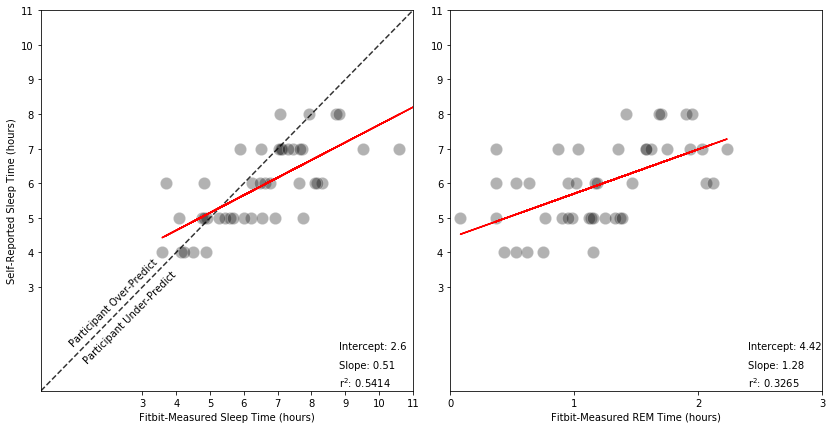

In [43]:
fig, axes = plt.subplots(1,2,figsize=(14,7))
ax = axes[0]
sns.scatterplot(x='TotalHoursAsleep',y='hours',color='black',alpha=0.3,s=150,data=sleepTime,ax=ax)
# x-axis
ax.set_xlim([0,11])
ax.set_xticks(np.arange(3,12))
ax.set_xlabel('Fitbit-Measured Sleep Time (hours)')
# y-axis
ax.set_ylim([0,11])
ax.set_yticks(np.arange(3,12))
ax.set_ylabel('Self-Reported Sleep Time (hours)')
# y=x
ax.plot([0,11],[0,11],linestyle='dashed',alpha=0.8,color='black')
ax.text(0.8,1.3,'Participant Over-Predict',rotation=45)
ax.text(1.2,0.8,'Participant Under-Predict',rotation=45)

X = sleepTime['TotalHoursAsleep'].values
Y = sleepTime['hours'].values
t = np.arange(len(X))
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) # make the predictions by the model

## Line of Best Fit
ax.plot(X[:,1],predictions,color='red')

top = 0
bot = 0
for i in range(len(predictions)):
    top += (predictions[i]-np.mean(Y))**2
    bot += (Y[i] - np.mean(Y))**2
rsqrd = top/bot

## Formatting Remainder of Axis
xlim = [0,11]
ylim = [0,11]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
### Print out the statistics
loc_x = max(xlim)-0.2*(max(xlim)-min(xlim))
loc_y = min(ylim)+0.01*(max(ylim)-min(ylim))
ax.text(loc_x,loc_y+0.1*(max(ylim)-min(ylim)),'Intercept: ' + str(round(model.params[0],2)))
ax.text(loc_x,loc_y+0.05*(max(ylim)-min(ylim)),'Slope: ' + str(round(model.params[1],2)))
ax.text(loc_x,loc_y,'r$^2$: ' + str(round(rsqrd,4)))

ax = axes[1]
sleepTime['TotalHoursREM'] = sleepTime['TotalMinutesREM']/60
sns.scatterplot(x='TotalHoursREM',y='hours',color='black',alpha=0.3,s=150,data=sleepTime,ax=ax)
# x-axis
ax.set_xlim([0,3])
ax.set_xticks(np.arange(0,4))
ax.set_xlabel('Fitbit-Measured REM Time (hours)')
# y-axis
ax.set_ylim([0,11])
ax.set_yticks(np.arange(3,12))
ax.set_ylabel('')

X = sleepTime['TotalHoursREM'].values
Y = sleepTime['hours'].values
t = np.arange(len(X))
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) # make the predictions by the model

## Line of Best Fit
ax.plot(X[:,1],predictions,color='red')

top = 0
bot = 0
for i in range(len(predictions)):
    top += (predictions[i]-np.mean(Y))**2
    bot += (Y[i] - np.mean(Y))**2
rsqrd = top/bot

## Formatting Remainder of Axis
xlim = [0,3]
ylim = [0,11]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
### Print out the statistics
loc_x = max(xlim)-0.2*(max(xlim)-min(xlim))
loc_y = min(ylim)+0.01*(max(ylim)-min(ylim))
ax.text(loc_x,loc_y+0.1*(max(ylim)-min(ylim)),'Intercept: ' + str(round(model.params[0],2)))
ax.text(loc_x,loc_y+0.05*(max(ylim)-min(ylim)),'Slope: ' + str(round(model.params[1],2)))
ax.text(loc_x,loc_y,'r$^2$: ' + str(round(rsqrd,4)))

#
plt.subplots_adjust(wspace=0.1)
plt.savefig('/Users/hagenfritz/Projects/utx000/reports/figures/framework_paper/ut3000-fitbit-beiwe-tst-tst-scatter.png')

plt.show()
plt.close()

## Restful Sleep
There should be some relationship between REM sleep and how restful the participants felt their sleep was.

/Users/hagenfritz/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:437: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)
/Users/hagenfritz/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:437: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


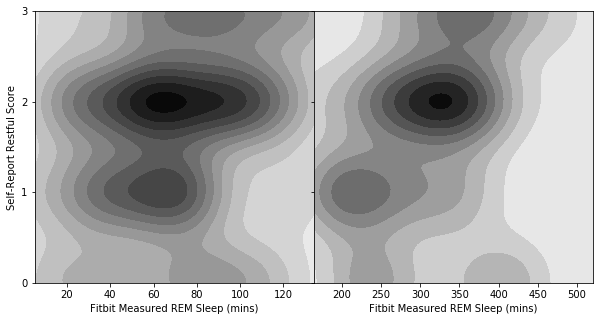

In [9]:
fig, axes = plt.subplots(1,2,figsize=(10,5),sharey=True)
#REM
ax = axes[0]
sns.kdeplot(sleepRestful['TotalMinutesREM'],sleepRestful['restful'],color='black',edgecolor='black',cut=0,shade=True,ax=ax)
# x-axis
ax.set_xlabel('Fitbit Measured REM Sleep (mins)')
# y-axis
ax.set_yticks(np.arange(4))
ax.set_ylabel('Self-Report Restful Score')
#NREM
ax = axes[1]
sns.kdeplot(sleepRestful['TotalMinutesNREM'],sleepRestful['restful'],color='black',edgecolor='black',cut=0,shade=True,ax=ax)
# x-axis
ax.set_xlabel('Fitbit Measured REM Sleep (mins)')
# y-axis
ax.set_yticks(np.arange(4))
ax.set_ylabel('')
# 
plt.subplots_adjust(wspace=0)
plt.savefig('/Users/hagenfritz/Projects/utx000/reports/figures/framework_paper/ut3000-fitbit-beiwe-REMandNREM-restful-density.png')
plt.show()
plt.close()

## Restful and Refreshed
They seem so similar - surely they are related.

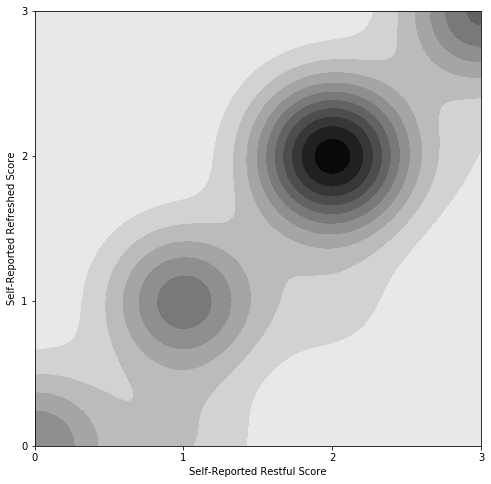

In [10]:
fig, ax = plt.subplots(figsize=(8,8))
sns.kdeplot(sleepRestful['restful'],sleepRefreshed['refreshed'],color='black',cut=0,shade=True,ax=ax)
# x-axis
ax.set_xlim([0,3])
ax.set_xticks(np.arange(4))
ax.set_xlabel('Self-Reported Restful Score')
# y-axis
ax.set_ylim([0,3])
ax.set_yticks(np.arange(4))
ax.set_ylabel('Self-Reported Refreshed Score')
# 
plt.savefig('/Users/hagenfritz/Projects/utx000/reports/figures/framework_paper/ut3000-beiwe-beiwe-restful-refreshed-density.png')
plt.show()
plt.close()

Author: Hagen Fritz <br> 
Date Created: 06/11/2020